# Import Libraries

In [175]:
import os
import subprocess
import requests
import tqdm

from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [176]:
# It's really important to add an accelerator to your notebook, as otherwise the submission will fail.
# We recomment using the P100 GPU rather than T4 as it's faster and will increase the chances of passing the time cut-off threshold.

if DEVICE != 'cuda':
    raise RuntimeError('Make sure you have added an accelerator to your notebook; the submission will fail otherwise!')

# Custom Configuration

## Seed Config 

In [177]:
torch.manual_seed(3047)

G_retain = torch.Generator()
G_retain.manual_seed(20)

G_forget = torch.Generator()
G_forget.manual_seed(30)

G_validate = torch.Generator()
G_validate.manual_seed(40)

## Testing Version or Submission Version 

Here at the time of **testing**, we will keep the **internet on**, set **test=True** and load pretrained cifar10 model to test our unlearning algorithm implementation. In this case, we will utilize some parts from the given starting kit by the competition organizers.<br>
**Link:** https://github.com/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb <br><br>
At the time of **submission**, **internet off** and **test=False**

In [178]:
test = True

# Load Dataset

In [179]:
# Helper functions for loading the CIFAR10 dataset.

if test:
    
    # The directory for a dataset and a pretrained model
    test_dir = './test'
    test_model_path = os.path.join(test_dir, "weights_resnet18_cifar10.pth")
    os.makedirs(test_dir, exist_ok=True)
    
    class PublicDataset(Dataset):
        
        def __init__(self, ds: Dataset):
            self._ds = ds
    
        def __len__(self):
            return len(self._ds)
    
        def __getitem__(self, index):
            item = self._ds[index]
            result = {
                'image': item[0],
                'image_id': index,
                'age_group': item[1],
                'age': item[1],
                'person_id': index,
            }
            return result
    
    def get_dataset(batch_size, thinning_param: int=1, root=test_dir) -> tuple[DataLoader, DataLoader, DataLoader, DataLoader]:
        
        # utils
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        # create dataset
        train_set = torchvision.datasets.CIFAR10(root=test_dir, train=True, download=True, transform=normalize)
        train_ds = PublicDataset(train_set)
        
        # download the forget and retain index split
        local_path = "forget_idx.npy"
        if not os.path.exists(local_path):
            response = requests.get(
                "https://storage.googleapis.com/unlearning-challenge/" + local_path
            )
            open(local_path, "wb").write(response.content)
            
        forget_idx = np.load(local_path)

        # construct indices of retain from those of the forget set
        forget_mask = np.zeros(len(train_set.targets), dtype=bool)
        forget_mask[forget_idx] = True
        retain_idx = np.arange(forget_mask.size)[~forget_mask]
        
        # split train set into a forget and a retain set
        forget_ds = Subset(train_ds, forget_idx)
        retain_ds = Subset(train_ds, retain_idx)
        
        full_val_set = torchvision.datasets.CIFAR10(root=test_dir, train=False, download=True, transform=normalize)
        
        test_set, val_set = torch.utils.data.random_split(full_val_set, [0.5, 0.5])
        
        val_ds = PublicDataset(val_set)
        test_ds = PublicDataset(test_set)

        retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
        forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
        validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

        return retain_loader, forget_loader, validation_loader, test_loader

In [180]:
# Helper functions for loading the hidden dataset.

if not test:
    
    def load_example(df_row):
        image = torchvision.io.read_image(df_row['image_path'])
        result = {
            'image': image,
            'image_id': df_row['image_id'],
            'age_group': df_row['age_group'],
            'age': df_row['age'],
            'person_id': df_row['person_id']
        }
        return result


    class HiddenDataset(Dataset):
        '''The hidden dataset.'''
        def __init__(self, split='train'):
            super().__init__()
            self.examples = []

            df = pd.read_csv(f'/kaggle/input/neurips-2023-machine-unlearning/{split}.csv')
            df['image_path'] = df['image_id'].apply(
                lambda x: os.path.join('/kaggle/input/neurips-2023-machine-unlearning/', 'images', x.split('-')[0], x.split('-')[1] + '.png'))
            df = df.sort_values(by='image_path')
            df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
            if len(self.examples) == 0:
                raise ValueError('No examples.')

        def __len__(self):
            return len(self.examples)

        def __getitem__(self, idx):
            example = self.examples[idx]
            image = example['image']
            image = image.to(torch.float32)
            example['image'] = image
            return example


    def get_dataset(batch_size):
        '''Get the dataset.'''
        retain_ds = HiddenDataset(split='retain')
        forget_ds = HiddenDataset(split='forget')
        val_ds = HiddenDataset(split='validation')

        retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True, generator=G_retain)
        forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True, generator=G_forget)
        validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, generator=G_validate)

        return retain_loader, forget_loader, validation_loader

# Unlearning Algorithm (1st Place)

https://www.kaggle.com/competitions/neurips-2023-machine-unlearning/discussion/458721

### Kullback-Leibler Divergence Loss 

https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss

Used in the **1st stage**

In [181]:
def kl_loss_sym(x,y):
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    return kl_loss(nn.LogSoftmax(dim=-1)(x),y)

### Contrastive Learning Loss

Used in the **second stage forget round**

In [182]:
# tau = temperature co-efficient
def cl_loss(outputs_forget, outputs_retain, tau=1.15):
    return (-1.0 * nn.LogSoftmax(dim=-1)(outputs_forget @ outputs_retain.T/tau)).mean()

### 2 Stage Training For Unlearning

In [183]:
# this will run at the time of submission

if not test:

    def unlearning(net, retain_loader, forget_loader, val_loader):

        # First Stage: KL-Divergence Optimization
        epochs = 1
        criterion = kl_loss_sym
        optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0)
        scheduler = None      # as just 1 epoch

        for ep in range(epochs):
            net.train()
            for sample in forget_loader:
                inputs = sample["image"]
                inputs = inputs.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
    
                uniform_psedo_label = torch.ones_like(outputs).to(DEVICE) / outputs.shape[1]            
                loss = criterion(outputs, uniform_psedo_label)
            
                loss.backward()
                optimizer.step()

                
        # Second Stage: Adverserial Fine Tuning (1. Forget Round , 2. Retain Round)
        epochs = 8
        retain_batch_size = 256
        criterion_forget = cl_loss
        criterion_retain = nn.CrossEntropyLoss()
        optimizer_forget = optim.SGD(net.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)
        optimizer_retain = optim.SGD(net.parameters(), lr=0.001 * retain_batch_size / 64 , 
                                     momentum=0.9, weight_decay=0.01)
        scheduler_forget = optim.lr_scheduler.CosineAnnealingLR(optimizer_forget, 
                                                         T_max=epochs*len(forget_loader), eta_min=1e-6)
        
        # generate unexpected random shuffling at retain set
        # two set (1 for forget round, another for retain round)
        retain_loader_forget = DataLoader(retain_loader.dataset, batch_size=retain_batch_size, shuffle=True)
        retain_loader_retain = DataLoader(retain_loader.dataset, batch_size=retain_batch_size, shuffle=True)

        net.train()
        
        for ep in range(epochs):
            net.train()
            
            # forget round
            for sample_forget, sample_retain in zip(forget_loader, retain_loader_forget):
                inputs_forget, inputs_retain = sample_forget["image"], sample_retain["image"]
                inputs_forget, inputs_retain = inputs_forget.to(DEVICE), inputs_retain.to(DEVICE)

                optimizer_forget.zero_grad()
                outputs_forget, outputs_retain = net(inputs_forget), net(inputs_retain).detach()
                
                # contrastive learning loss
                loss = criterion_forget(outputs_forget, outputs_retain)
                loss.backward()
                optimizer_forget.step()
                
                scheduler_forget.step()
                
            # retain round
            for sample in retain_loader_retain:
                inputs, labels = sample["image"], sample["age_group"]
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                optimizer_retain.zero_grad()
                outputs = net(inputs)
                                
                loss = criterion_retain(outputs, labels)
                loss.backward()
                optimizer_retain.step()
                
        return net

# Evaluation Using Loss & Accuracy

In [184]:
def calculate_acc_loss(net, dataloader, criterion, device = 'cuda'):
    net.eval()
    total_samp = 0
    total_acc = 0
    total_loss = 0.0
    
    for sample in dataloader:
        images, labels = sample['image'].to(device), sample['age_group'].to(device)
        _pred = net(images)
        total_samp += len(labels)
        loss = criterion(_pred, labels)
        total_loss += loss.item()
        total_acc += (_pred.max(1)[1] == labels).float().sum().item()

    mean_loss = total_loss / len(dataloader) * 100.0
    mean_acc = total_acc / total_samp * 100.0
    
    return mean_loss, mean_acc

In [185]:
# this will be run at the time of testing
# same algorithm as before; just some extra validation and print the results to check algorithm

if test:
    
    def unlearning(net, retain_loader, forget_loader, val_loader):
        
        print("----------------------------------")
        
        col_names = ["Stage-Epoch", "Set Type", "Loss(%)", "Accuracy(%)"]
        table = []
        
        # test criterion
        criterion_test = nn.CrossEntropyLoss()

        # First Stage: KL-Divergence Optimization
        epochs = 1
        criterion = kl_loss_sym
        optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0)
        scheduler = None      # as just 1 epoch
        
        # testing
        net.eval()
        l, a = calculate_acc_loss(net, forget_loader, criterion_test)
        table.append(["Before 1st Stage", "Forget", l, a])
        l, a = calculate_acc_loss(net, validation_loader, criterion_test)
        table.append(["Before 1st Stage", "Valid", l, a])

        for ep in range(epochs):
            net.train()
            for sample in forget_loader:
                inputs = sample["image"]
                inputs = inputs.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
    
                uniform_psedo_label = torch.ones_like(outputs).to(DEVICE) / outputs.shape[1]            
                loss = criterion(outputs, uniform_psedo_label)
            
                loss.backward()
                optimizer.step()
                
        # testing
        l, a = calculate_acc_loss(net, forget_loader, criterion_test)
        table.append(["After 1st Stage", "Forget", l, a])
        l, a = calculate_acc_loss(net, validation_loader, criterion_test)
        table.append(["After 1st Stage", "Valid", l, a])

                
        # Second Stage: Adverserial Fine Tuning (1. Forget Round , 2. Retain Round)
        epochs = 8
        retain_batch_size = 256
        criterion_forget = cl_loss
        criterion_retain = nn.CrossEntropyLoss()
        optimizer_forget = optim.SGD(net.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)
        optimizer_retain = optim.SGD(net.parameters(), lr=0.001 * retain_batch_size / 64 , 
                                     momentum=0.9, weight_decay=0.01)
        scheduler_forget = optim.lr_scheduler.CosineAnnealingLR(optimizer_forget, 
                                                         T_max=epochs*len(forget_loader), eta_min=1e-6)
        
        # generate unexpected random shuffling at retain set
        # two set (1 for forget round, another for retain round)
        retain_loader_forget = DataLoader(retain_loader.dataset, batch_size=retain_batch_size, shuffle=True)
        retain_loader_retain = DataLoader(retain_loader.dataset, batch_size=retain_batch_size, shuffle=True)

        net.train()
        
        for ep in tqdm.trange(epochs):
            net.train()
            
            # forget round
            for sample_forget, sample_retain in zip(forget_loader, retain_loader_forget):
                inputs_forget, inputs_retain = sample_forget["image"], sample_retain["image"]
                inputs_forget, inputs_retain = inputs_forget.to(DEVICE), inputs_retain.to(DEVICE)

                optimizer_forget.zero_grad()
                outputs_forget, outputs_retain = net(inputs_forget), net(inputs_retain).detach()
                
                # contrastive learning loss
                loss = criterion_forget(outputs_forget, outputs_retain)
                loss.backward()
                optimizer_forget.step()
                
                scheduler_forget.step()
                
            # retain round
            for sample in retain_loader_retain:
                inputs, labels = sample["image"], sample["age_group"]
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                optimizer_retain.zero_grad()
                outputs = net(inputs)
                                
                loss = criterion_retain(outputs, labels)
                loss.backward()
                optimizer_retain.step()
                
            # testing
            stage_epoch = "Stage 2 - Epoch " + str(ep)
            l, a = calculate_acc_loss(net, forget_loader, criterion_test)
            table.append([stage_epoch, "Forget", l, a])
            l, a = calculate_acc_loss(net, retain_loader_retain, criterion_test)
            table.append([stage_epoch, "Retain", l, a])
            l, a = calculate_acc_loss(net, validation_loader, criterion_test)
            table.append([stage_epoch, "Valid", l, a])
            
        print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))
        
        return net

### Loss Acc Evaluation & Test Submission

In [186]:
if test:
    
    n_checkpoints = 1  # in the submission, there will be 512 points
    
    if not os.path.exists(test_model_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth")
        open(test_model_path, "wb").write(response.content)    
    
    os.makedirs('/kaggle/tmp', exist_ok=True)
    retain_loader, forget_loader, validation_loader, test_loader = get_dataset(64)
    net = resnet18(weights=None, num_classes=10)
    net.to(DEVICE)
    for i in tqdm.trange(n_checkpoints):
        net.load_state_dict(torch.load(test_model_path))
        net = unlearning(net, retain_loader, forget_loader, validation_loader)
        state = net.state_dict()
        torch.save(state, f'/kaggle/tmp/unlearned_checkpoint_{i}.pth')

#     # Ensure that submission.zip will contain exactly n_checkpoints 
#     unlearned_ckpts = os.listdir('/kaggle/tmp')
#     if len(unlearned_ckpts) != n_checkpoints:
#         raise RuntimeError('The submission will throw an exception otherwise.')

#     subprocess.run('zip submission.zip /kaggle/tmp/*.pth', shell=True)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------



100%|██████████| 1/1 [04:44<00:00, 284.01s/it]

╒═══════════════════╤════════════╤═══════════╤═══════════════╕
│ Stage-Epoch       │ Set Type   │   Loss(%) │   Accuracy(%) │
╞═══════════════════╪════════════╪═══════════╪═══════════════╡
│ Before 1st Stage  │ Forget     │   2.17303 │       99.32   │
├───────────────────┼────────────┼───────────┼───────────────┤
│ Before 1st Stage  │ Valid      │  42.8076  │       88.64   │
├───────────────────┼────────────┼───────────┼───────────────┤
│ After 1st Stage   │ Forget     │ 228.198   │       19.24   │
├───────────────────┼────────────┼───────────┼───────────────┤
│ After 1st Stage   │ Valid      │ 229.97    │       19.66   │
├───────────────────┼────────────┼───────────┼───────────────┤
│ Stage 2 - Epoch 0 │ Forget     │  12.7504  │       97.06   │
├───────────────────┼────────────┼───────────┼───────────────┤
│ Stage 2 - Epoch 0 │ Retain     │   7.65043 │       99.1244 │
├───────────────────┼────────────┼───────────┼───────────────┤
│ Stage 2 - Epoch 0 │ Valid      │  36.626   │       87

## Comparison With Trained Model Exclusively on Retain Set 

In [187]:
if test:
    
    # download weights of a model trained exclusively on the retain set
    local_path = "retrain_weights_resnet18_cifar10.pth"
    if not os.path.exists(local_path):
        response = requests.get(
            "https://storage.googleapis.com/unlearning-challenge/" + local_path
        )
        open(local_path, "wb").write(response.content)

    weights_pretrained = torch.load(local_path, map_location=DEVICE)

    # load model with pre-trained weights
    rt_model = resnet18(weights=None, num_classes=10)
    rt_model.load_state_dict(weights_pretrained)
    rt_model.to(DEVICE)
    rt_model.eval()

    # test criterion
    criterion = nn.CrossEntropyLoss()

    print("------------ Exclusive Retrained Model---------------")
    l, a = calculate_acc_loss(rt_model, retain_loader, criterion)
    print(f"Retain set accuracy: {a:0.2f}%")
    print(f"Retain set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(rt_model, forget_loader, criterion)
    print(f"Forget set accuracy: {a:0.2f}%")
    print(f"Forget set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(rt_model, validation_loader, criterion)
    print(f"Validation set accuracy: {a:0.2f}%")
    print(f"Validation set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(rt_model, test_loader, criterion)
    print(f"Test set accuracy: {a:0.2f}%")
    print(f"Test set loss: {l:0.2f}%")
    
    print("------------ Unlearned Model ---------------")
    l, a = calculate_acc_loss(net, retain_loader, criterion)
    print(f"Retain set accuracy: {a:0.2f}%")
    print(f"Retain set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(net, forget_loader, criterion)
    print(f"Forget set accuracy: {a:0.2f}%")
    print(f"Forget set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(net, validation_loader, criterion)
    print(f"Validation set accuracy: {a:0.2f}%")
    print(f"Validation set loss: {l:0.2f}%")
    l, a = calculate_acc_loss(net, test_loader, criterion)
    print(f"Test set accuracy: {a:0.2f}%")
    print(f"Test set loss: {l:0.2f}%")

------------ Exclusive Retrained Model---------------
Retain set accuracy: 99.53%
Retain set loss: 1.81%
Forget set accuracy: 88.20%
Forget set loss: 46.07%
Validation set accuracy: 88.00%
Validation set loss: 46.41%
Test set accuracy: 87.94%
Test set loss: 49.73%
------------ Unlearned Model ---------------
Retain set accuracy: 100.00%
Retain set loss: 2.89%
Forget set accuracy: 95.50%
Forget set loss: 18.57%
Validation set accuracy: 88.60%
Validation set loss: 38.61%
Test set accuracy: 87.86%
Test set loss: 40.43%


# Evaluation using MIA

**Reference:** https://github.com/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb<br>
We will evaluate the trained models using Simple Membership Inference Attacks(MIA). This is **not used** as evaluation metric for the competition.

This MIA consists of a **logistic regression model** that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained models

## Visualize Pre-trained Model 

In [188]:
if test:
    
    def compute_losses(model_, loader):
        """Auxiliary function to compute per-sample losses"""

        criterion = nn.CrossEntropyLoss(reduction="none")
        all_losses = []

        for sample in loader:
            images, labels = sample['image'].to(DEVICE), sample['age_group'].to(DEVICE)
            logits = model_(images)
            
            losses = criterion(logits, labels).numpy(force=True)
            for l in losses:
                all_losses.append(l)

        return np.array(all_losses)

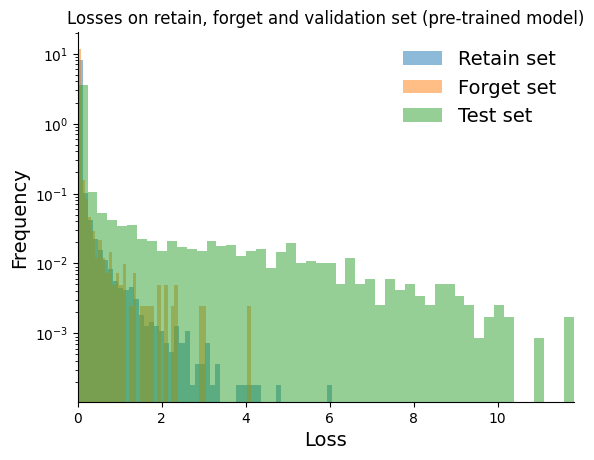

In [189]:
if test:
    
    # load model with pre-trained weights
    model = resnet18(weights=None, num_classes=10)
    weights_pretrained = torch.load(test_model_path, map_location=DEVICE)
    model.load_state_dict(weights_pretrained)
    model.to(DEVICE)
    model.eval()

    retain_losses = compute_losses(model, retain_loader)
    forget_losses = compute_losses(model, forget_loader)
    test_losses = compute_losses(model, test_loader)
    
    plt.title("Losses on retain, forget and validation set (pre-trained model)")
    plt.hist(retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")
    plt.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    plt.xlabel("Loss", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim((0, np.max(test_losses)))
    plt.yscale("log")
    plt.legend(frameon=False, fontsize=14)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()

As per the above plot, the distributions of losses are quite different between the train and validation sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't.

## MIA Implementation 

Now, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last part of this MIA section for additional discussion and for computing that reference point.

In [190]:
if test:
    
    def simple_mia(sample_loss, members, n_splits=10, random_state=42):
        """Computes cross-validation score of a membership inference attack.

        Args:
          sample_loss : array_like of shape (n,).
            objective function evaluated on n samples.
          members : array_like of shape (n,),
            whether a sample was used for training.
          n_splits: int
            number of splits to use in the cross-validation.
        Returns:
          scores : array_like of size (n_splits,)
        """

        unique_members = np.unique(members)
        if not np.all(unique_members == np.array([0, 1])):
            raise ValueError("members should only have 0 & 1s")

        attack_model = linear_model.LogisticRegression()
        cv = model_selection.StratifiedShuffleSplit(
            n_splits=n_splits, random_state=random_state
        )
        return model_selection.cross_val_score(
            attack_model, sample_loss, members, cv=cv, scoring="accuracy"
        )

### MIA on Original Model 

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the validation set.

In [191]:
if test:
    
    forget_losses = compute_losses(model, forget_loader)
    
    # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(test_losses)]

    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)

    print(f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images")

The MIA has an accuracy of 0.580 on forgotten vs unseen images


### MIA on Unlearned Model 

We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [192]:
if test:

    net_forget_losses = compute_losses(net, forget_loader)
    net_test_losses = compute_losses(net, test_loader)
    
    np.random.shuffle(net_forget_losses)
    net_forget_losses = net_forget_losses[: len(test_losses)]

    net_samples_mia = np.concatenate((net_test_losses, net_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(net_test_losses) + [1] * len(net_forget_losses)

    net_mia_scores = simple_mia(net_samples_mia, labels_mia)

    print(f"The MIA has an accuracy of {net_mia_scores.mean():.3f} on forgotten vs unseen images")

The MIA has an accuracy of 0.517 on forgotten vs unseen images


## Comparison With Original Model 

From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and validation set. From the below figure, we can observe that the distributions of forget and validation losses are more similar under the unlearned model compared to the original model, as expected.

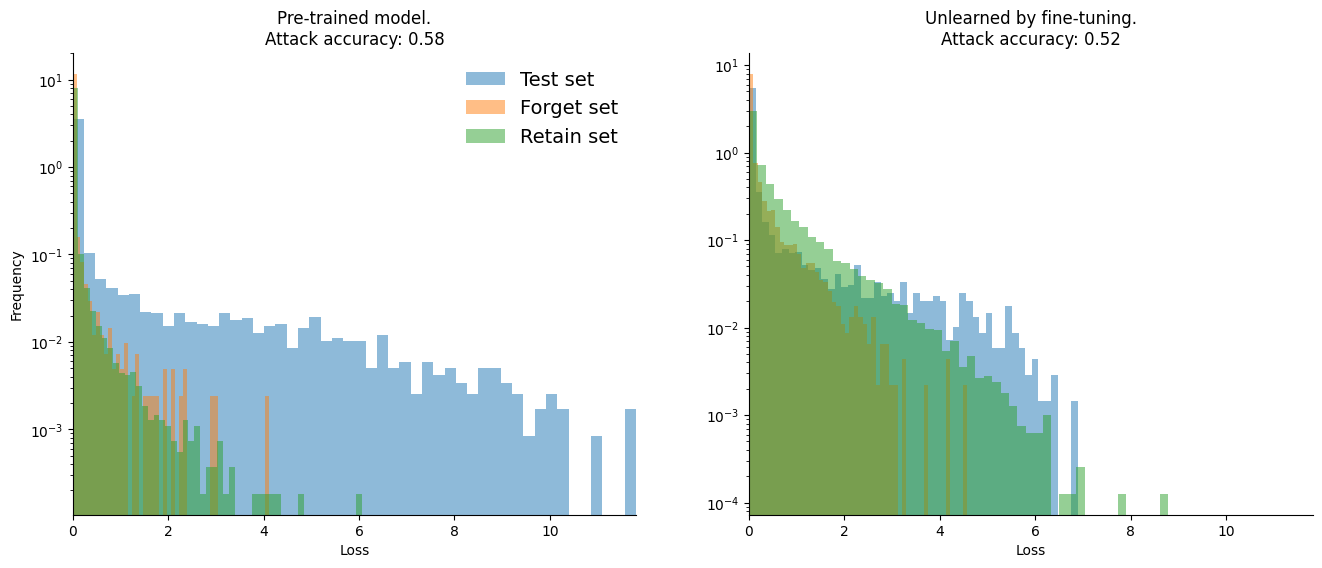

In [193]:
if test:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
    ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    ax1.hist(retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")

    ax2.set_title(f"Unlearned by fine-tuning.\nAttack accuracy: {net_mia_scores.mean():0.2f}")
    ax2.hist(net_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(net_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    ax2.hist(net_retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

## Comparison With Trained Model Exclusively on Retain Set 

Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

First, we will compute the MIA score on Re-trained model exclusive

In [194]:
if test:

    rt_test_losses = compute_losses(rt_model, test_loader)
    rt_forget_losses = compute_losses(rt_model, forget_loader)
    rt_retain_losses = compute_losses(rt_model, retain_loader)

    rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)
    
    rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

    print(f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images")

The MIA has an accuracy of 0.498 on forgotten vs unseen images


Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

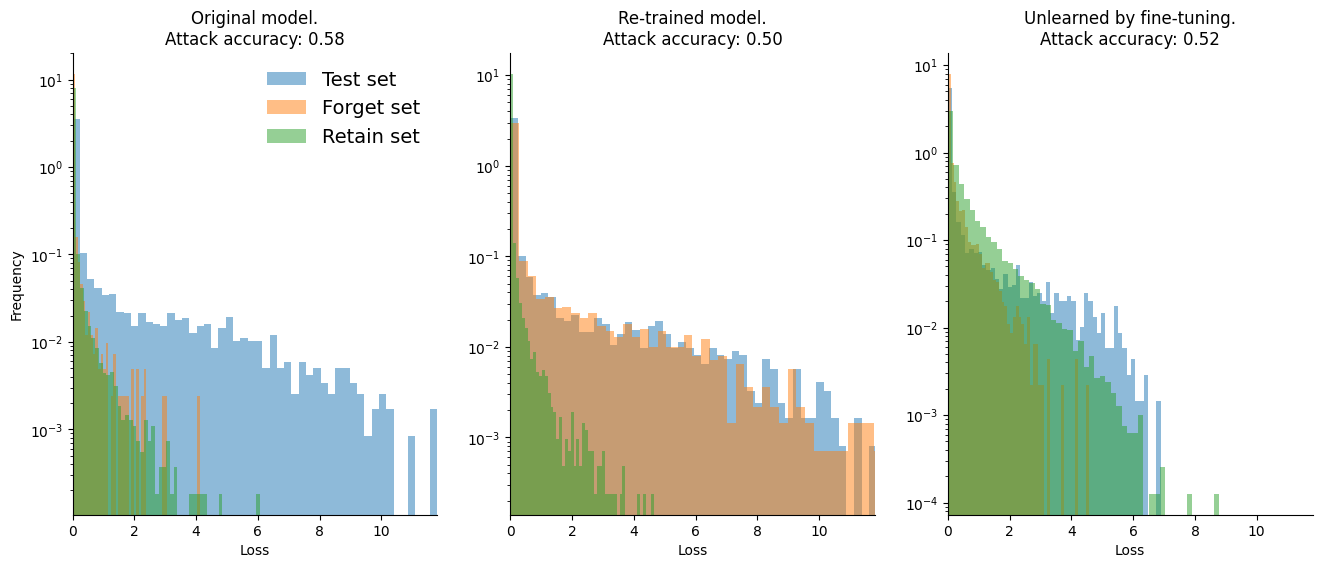

In [195]:
if test:
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    
    ax1.set_title(f"Original model.\nAttack accuracy: {mia_scores.mean():0.2f}")
    ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    ax1.hist(retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")

    ax2.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
    ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    ax2.hist(rt_retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")

    ax3.set_title(f"Unlearned by fine-tuning.\nAttack accuracy: {net_mia_scores.mean():0.2f}")
    ax3.hist(net_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
    ax3.hist(net_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
    ax3.hist(net_retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax3.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax3.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses)))
    ax2.set_xlim((0, np.max(test_losses)))
    ax3.set_xlim((0, np.max(test_losses)))
    for ax in (ax1, ax2, ax3):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.legend(frameon=False, fontsize=14)
    plt.show()

# Submission

In [196]:
if not test:
    
    if os.path.exists('/kaggle/input/neurips-2023-machine-unlearning/empty.txt'):
        # mock submission
        subprocess.run('touch submission.zip', shell=True)
    else:

        # Note: it's really important to create the unlearned checkpoints outside of the working directory 
        # as otherwise this notebook may fail due to running out of disk space.
        # The below code saves them in /kaggle/tmp to avoid that issue.

        os.makedirs('/kaggle/tmp', exist_ok=True)
        retain_loader, forget_loader, validation_loader = get_dataset(64)
        net = resnet18(weights=None, num_classes=10)
        net.to(DEVICE)
        for i in range(512):
            net.load_state_dict(torch.load('/kaggle/input/neurips-2023-machine-unlearning/original_model.pth'))
            unlearning(net, retain_loader, forget_loader, validation_loader)
            state = net.state_dict()
            torch.save(state, f'/kaggle/tmp/unlearned_checkpoint_{i}.pth')

        # Ensure that submission.zip will contain exactly 512 checkpoints 
        # (if this is not the case, an exception will be thrown).
        unlearned_ckpts = os.listdir('/kaggle/tmp')
        if len(unlearned_ckpts) != 512:
            raise RuntimeError('Expected exactly 512 checkpoints. The submission will throw an exception otherwise.')

        subprocess.run('zip submission.zip /kaggle/tmp/*.pth', shell=True)